In [ ]:
#!conda install -c bioconda -c conda-forge -y cgmlst-dists
#!conda install -c conda-forge -y rpy2 pandas
#!conda install -c conda-forge -y glpk libxml2 r-igraph
#!conda install -c bioconda -y genomic_address_service

In [35]:
!wget -q https://github.com/tseemann/cgmlst-dists/raw/master/test/100.tab
!head -n 16 100.tab >15.tab
!cgmlst-dists 15.tab >15.dist.tab

This is cgmlst-dists 0.4.0
Loaded 15 samples x 3016 allele calls
Calculating distances: 100.00%
Writing distance matrix to stdout...

Done.


In [36]:
!gas mcluster -i 15.dist.tab -o 15.dist.gas.mcluster.output -t 2000,1000,500,200,100,50,10,5,0

In [37]:
import pandas as pd

results = pd.read_csv("15.dist.gas.mcluster.output/clusters.text",sep="\t")
results.sort_values("address")


,id,address,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9
5,ASM92262,1.1.1.1.1.1.1.1.1,1,1,1,1,1,1,1,1,1
10,ASM92192,1.1.1.1.2.2.2.2.2,1,1,1,1,2,2,2,2,2
9,ASM92193,2.2.2.2.3.3.3.3.3,2,2,2,2,3,3,3,3,3
12,ASM92190,2.2.2.2.3.3.3.3.4,2,2,2,2,3,3,3,3,4
6,ASM92248,2.2.2.3.4.4.4.4.5,2,2,2,3,4,4,4,4,5
4,ASM92263,3.3.3.4.5.5.5.5.6,3,3,3,4,5,5,5,5,6
8,ASM92197,3.3.3.4.6.6.6.6.7,3,3,3,4,6,6,6,6,7
3,ASM92264,3.3.3.5.7.7.7.7.8,3,3,3,5,7,7,7,7,8
11,ASM92191,3.3.3.5.7.7.7.7.9,3,3,3,5,7,7,7,7,9
2,ASM92271,3.3.3.5.7.7.7.8.10,3,3,3,5,7,7,7,8,10


In [38]:
!cut -f 1,3 15.dist.gas.mcluster.output/clusters.text >15.metadata.tsv
!sed -i 's@id\tlevel_1@sample\tgroup@g' 15.metadata.tsv

In [8]:
import os
os.environ['R_HOME'] = '/opt/conda/lib/R'
import rpy2
%reload_ext rpy2.ipython

#### from https://github.com/zxgsy520/bioyicgmlst.git

In [10]:
%%R
#install.packages("igraph")

library(igraph)
options(bitmapType='cairo') #关闭服务器与界面的互动响应


cluster_group <- function(group){
    
    groupid <- unique(group$group)
    r <- list()
    n <- 0
    for (i in groupid){
        n <- n + 1
        r[paste(n, "", sep="")] <- list(which(group$group==i))
        #r <- c(r, list(which(group$group==i)))
    }

    return(r)
}


plot_mst_igraph <- function(file, prefix, groupf=FALSE){
    
    data <- read.table(file, header=T, row.names=1, sep="\t")
    samples <- colnames(data)
    samplelen <- length(samples)
  
    newdata <- matrix(1:samplelen*samplelen, samplelen, samplelen, byrow=T) #转换为矩阵
    n <- 0
    for (i in samples){
        n <- n + 1
        mat <- as.matrix(data[,i])
        newdata[,n] <- mat
    }
   
    clgroup <- ""
    if (groupf!=FALSE){
        group <- read.delim(groupf, sep="\t", stringsAsFactors=FALSE, header=TRUE)
        colnames(group) <- c("sample", "group")
        rownames(group) <- group$sample
        group <- group[samples, ]
        clgroup <- cluster_group(group)
        
    }
   
    mst <- graph.adjacency(newdata, weighted=TRUE, mode="undirected")
    mst <- minimum.spanning.tree(mst, weights=graph_attr(mst, "weight"))
    V(mst)$label <- samples

    pdf(paste(prefix, ".mst.pdf", sep=""))
    a <- dev.cur()
    png(paste(prefix, ".mst.png", sep=""), width=1600, height=1600, res=72*3)
    dev.control('enable')
    #mstcw <- cluster_walktrap(mst)
    #mstcw <- cluster_edge_betweenness(mst)
    #plot(mstcw, mst)

    if (groupf!=FALSE){
        plot(mst, edge.label=E(mst)$weight, vertex.label=samples,
             layout=layout_as_tree(mst, circular=TRUE), #layout_as_tree(mst, circular=TRUE)(局方式发散), layout=layout_in_circle(圆形布局) 
             vertex.shape="circle", #节点边框none为无方框，circle为圆形边框，rectangle为方形边框
             vertex.label.cex=1, #节点字体大小
             vertex.size=5, #节点大小 map(degree(data), c(1, 20)) 节点大小根据联系人多少设置
             vertex.label.dist=0.5,
             edge.curved=0.1,
             edge.width=1.5,
             edge.label.cex=0.8,
             edge.color="green",
             mark.groups=clgroup #添加分组
             )
    }else{
        plot(mst, edge.label=E(mst)$weight, vertex.label=samples,
             layout=layout_as_tree(mst, circular=TRUE), #layout_as_tree(mst, circular=TRUE)(局方式发散), layout=layout_in_circle(圆形布局) 
             vertex.shape="circle", #节点边框none为无方框，circle为圆形边框，rectangle为方形边框
             vertex.label.cex=1, #节点字体大小
             vertex.size=5, #节点大小 map(degree(data), c(1, 20)) 节点大小根据联系人多少设置
             vertex.label.dist=0.5,
             edge.curved=0.1,
             edge.width=1.5,
             edge.label.cex=0.8,
             edge.color="green"
             )
    }
    dev.copy(which=a)#复制png的图形给pdf
    dev.off()
    dev.off()

    V(mst)$shape <- "circle"
    V(mst)$size <- 5
    V(mst)$label.cex <- 1
    V(mst)$label.dist <- 0.5
    E(mst)$label <- E(mst)$weight
    E(mst)$width <- 1.5
    E(mst)$curved <- 0.2
    E(mst)$label.cex <- 0.8
    E(mst)$color <- "green"
    
    write_graph(mst, paste(prefix, ".mst.graphml", sep=""), "graphml")
}

In [39]:
%%R
#plot_mst_igraph("/home/jovyan/work/PRJNA722154/jupyter.notebook/bioyicgmlst/example/distances.tab",  "groupf", "/home/jovyan/work/PRJNA722154/jupyter.notebook/bioyicgmlst/example/group.list")
plot_mst_igraph("15.dist.tab",  "groupf", "15.metadata.tsv")


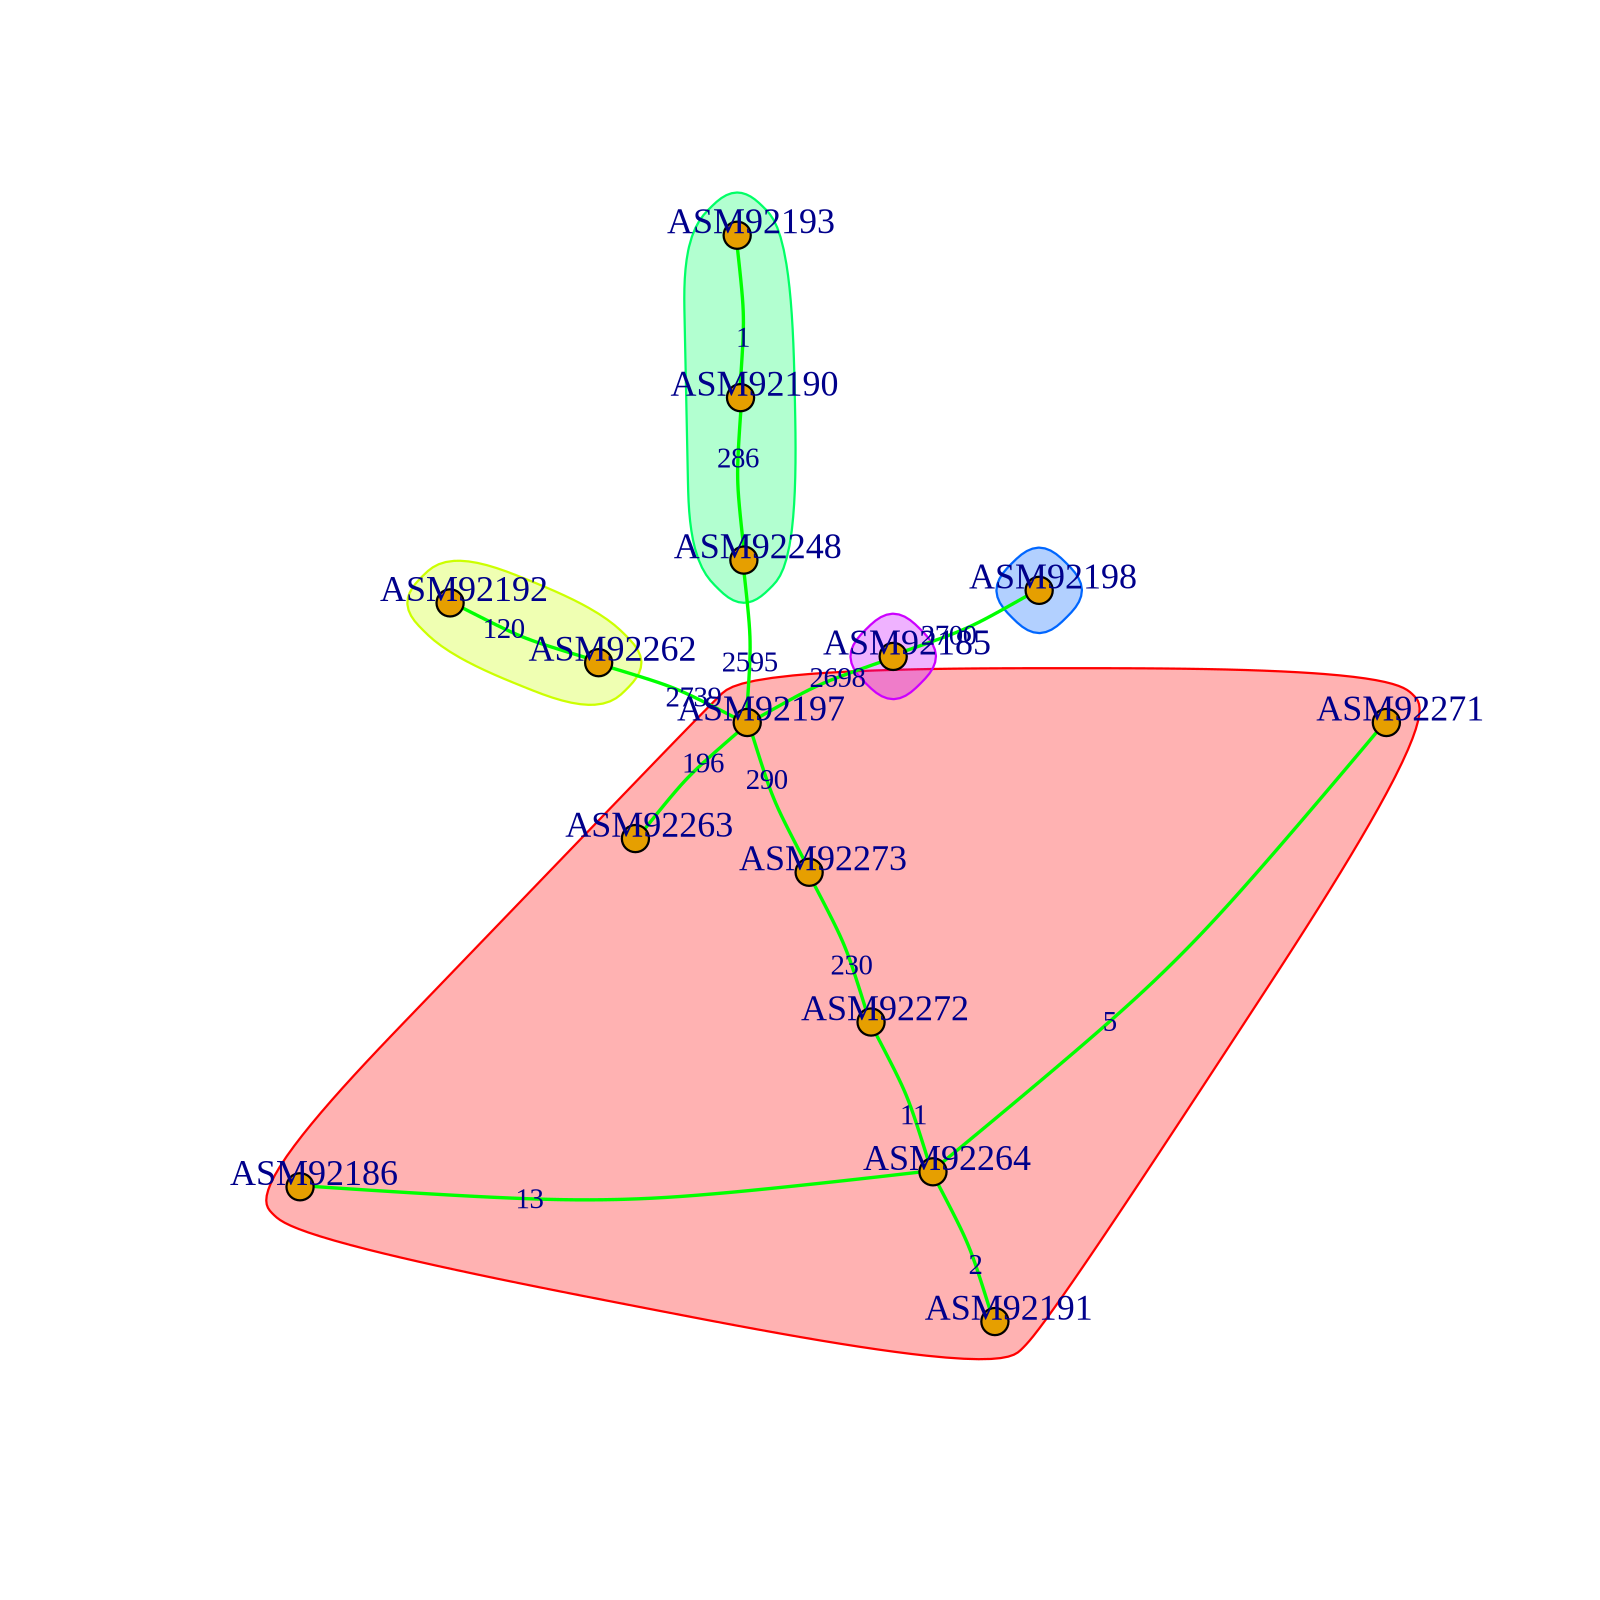

In [40]:
from IPython.display import Image
Image(filename='groupf.mst.png')